In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score


In [69]:
# Define your configuration
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}


In [70]:
# Define the paths to your training and validation datasets
train_directory = '/content/drive/MyDrive/dataset2/Emotions Dataset/Emotions Dataset/train'
val_directory = '/content/drive/MyDrive/dataset2/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'nothing', 'sad']

# Load your training and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,  # CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [71]:
# Data augmentation for the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Add normalization
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

@tf.function
def preprocess_data(x, y):
    x = data_augmentation(x)
    x = normalization_layer(x)
    return x, y

train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)

In [73]:
# Define a custom R2 metric
def r2_metric(y_true, y_pred):
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    r2 = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
    return r2

In [74]:
# Create the model with dropout and regularization
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    tf.keras.layers.Conv2D(CONFIGURATION["N_FILTERS"], CONFIGURATION["KERNEL_SIZE"], padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"]),
    tf.keras.layers.Conv2D(2 * CONFIGURATION["N_FILTERS"], CONFIGURATION["KERNEL_SIZE"], padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"]),
    tf.keras.layers.Conv2D(2 * 2 * CONFIGURATION["N_FILTERS"], CONFIGURATION["KERNEL_SIZE"], padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(CONFIGURATION["N_DENSE_1"], activation='relu', kernel_regularizer=tf.keras.regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    tf.keras.layers.Dropout(CONFIGURATION["DROPOUT_RATE"]),  # Add dropout
    tf.keras.layers.Dense(CONFIGURATION["N_DENSE_2"], activation='relu', kernel_regularizer=tf.keras.regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    tf.keras.layers.Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')
])

# Compile the model with custom R2 metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), r2_metric]
)

In [79]:
# Set up training callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, save_weights_only=False, monitor="val_categorical_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
]

In [80]:
# Train the model
history = model.fit(train_dataset, epochs=CONFIGURATION["N_EPOCHS"], validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 1.0364 - categorical_accuracy: 0.5015 - r2_metric: 0.0815

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - 98s 444ms/step - loss: 1.0364 - categorical_accuracy: 0.5015 - r2_metric: 0.0815 - val_loss: 0.9494 - val_categorical_accuracy: 0.5492 - val_r2_metric: 0.1499 - lr: 0.0010
Epoch 2/10
213/213 [==============================] - 95s 444ms/step - loss: 0.9033 - categorical_accuracy: 0.5901 - r2_metric: 0.2012 - val_loss: 0.8910 - val_categorical_accuracy: 0.5931 - val_r2_metric: 0.2127 - lr: 0.0010
Epoch 3/10
213/213 [==============================] - 111s 518ms/step - loss: 0.8460 - categorical_accuracy: 0.6152 - r2_metric: 0.2574 - val_loss: 0.8531 - val_categorical_accuracy: 0.6251 - val_r2_metric: 0.2570 - lr: 0.0010
Epoch 4/10
213/213 [==============================] - 111s 518ms/step - loss: 0.8069 - categorical_accuracy: 0.6302 - r2_metric: 0.2911 - val_loss: 0.8380 - val_categorical_accuracy: 0.6225 - val_r2_metric: 0.2723 - lr: 0.0010
Epoch 5/10
213/213 [==============================] - 98s 457ms/step - loss: 0.7572 - categorical_accurac

In [81]:
# Evaluate the model
val_loss, val_accuracy, val_r2 = model.evaluate(val_dataset)

print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Validation R2: {val_r2:.4f}")

2278/2278 [==============================] - 31s 13ms/step - loss: 0.6713 - categorical_accuracy: 0.7199 - r2_metric: 0.4269
Validation loss: 0.6713, Validation accuracy: 0.7199, Validation R2: 0.4269


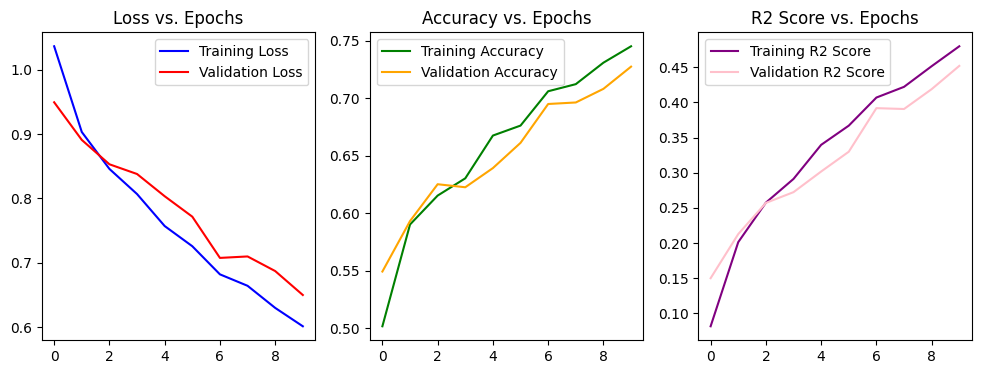

In [85]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], label="Training Loss", color='blue')  # Change color to blue
plt.plot(history.history["val_loss"], label="Validation Loss", color='red')  # Change color to red
plt.legend()
plt.title("Loss vs. Epochs")

plt.subplot(1, 3, 2)
plt.plot(history.history["categorical_accuracy"], label="Training Accuracy", color='green')  # Change color to green
plt.plot(history.history["val_categorical_accuracy"], label="Validation Accuracy", color='orange')  # Change color to orange
plt.legend()
plt.title("Accuracy vs. Epochs")

plt.subplot(1, 3, 3)
plt.plot(history.history["r2_metric"], label="Training R2 Score", color='purple')  # Change color to purple
plt.plot(history.history["val_r2_metric"], label="Validation R2 Score", color='pink')  # Change color to pink
plt.legend()
plt.title("R2 Score vs. Epochs")

plt.show()


# Save the trained model
model.save("emotion_model.h5")

1/1 [==============================] - 0s 102ms/step


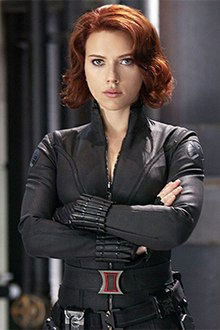

Predicted Emotion: sad


In [91]:
# Provide the path to the image you want to predict
image_path = "/content/blackWindow.jpg"

# Define a function to preprocess an image
def preprocess_input_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Define a function to predict emotion
def predict_emotion(image_path):
    input_img = preprocess_input_image(image_path)
    predictions = model.predict(input_img)
    class_names = CONFIGURATION["CLASS_NAMES"]
    predicted_emotion = class_names[np.argmax(predictions)]
    return predicted_emotion

# Make a prediction
predicted_emotion = predict_emotion(image_path)

# Display the input image
from IPython.display import Image, display
display(Image(filename=image_path))

# Display the predicted emotion
print("Predicted Emotion:", predicted_emotion)